In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import os
import datetime
import mplfinance as mpf
import matplotlib.pyplot as plt

In [ ]:
# Dataset Selection and Description
# Domain	Dataset	Source	Features	Website / APIs
# Energy	GEFCom2014	Kaggle	Hourly energy consumption, temperature	https://www.kaggle.com/code/raimondomelis/lab-time-series-linear-regression-cnn/notebook
# Electricity Load Diagrams 2011-2014	UCI	Electricity consumption data (hourly)	https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014
# Finance	Stock Prices (AAPL, GOOGL, etc.)	Yahoo Finance	Open, High, Low, Close, Volume	https://finance.yahoo.com/quote/AAPL/history?p=AAPL / APIs (See Python code)
# Climate	GlobalLandTemperatures	Kaggle	Temperature, Date	https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
# Retail	Store Sales - Time Series Forecasting	Kaggle	Store sales, Date, Promotions	https://www.kaggle.com/competitions/store-sales-time-series-forecasting
# Transport	Bike Sharing Dataset	UCI	Hourly bike rental counts, weather data https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset 

In [ ]:
## Data Preprocessing

def load_finance_data(ticker):
    data = yf.download(ticker, start="2010-01-01", end="2023-12-31")
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    data['Returns'] = data['Close'].pct_change().fillna(0)
    data['Ticker'] = ticker  # Add ticker column for identification
    return data

def add_time_features(df):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
    return df

# Tickers list
stocks = ['TSLA', 'BTC-USD', 'PXE', 'JPY=X', 'ES=F', '%5EVIX']

# Combined DataFrame to store all tickers' data
combined_data = pd.DataFrame()

for ticker in stocks:
    finance_data = load_finance_data(ticker)
    
    # Handling Missing Values
    # finance_data = finance_data.ffill()
    
    finance_data = add_time_features(finance_data)
    scaler = MinMaxScaler()
    if 'Close' in finance_data.columns:
        finance_data['Close_Scaled'] = scaler.fit_transform(finance_data[['Close']])
    
    # Append to the combined DataFrame
    combined_data = pd.concat([combined_data, finance_data], axis=0)

# Reset index to ensure consistency after concatenation
combined_data.reset_index(inplace=True)        
        
# Display the first few rows of the combined normalized data
print(combined_data.head())

In [ ]:
# variables to tune your plots

# valid periods: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
period = '1d'

 # valid intervals: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo
interval = '5m'

# method to grab data and plot the data
def plot_stocks_df(stocks, period='1d' , interval='1m'):
    for stock in stocks:
								# Downloading the stock data
								plt.figure()
								temp = yf.Ticker(stock)
								hist = temp.history(period=period, interval=interval)

								# Converting columns to float where necessary
								hist['Open'] = pd.to_numeric(hist['Open'], errors='coerce')
								hist['High'] = pd.to_numeric(hist['High'], errors='coerce')
								hist['Low'] = pd.to_numeric(hist['Low'], errors='coerce')
								hist['Close'] = pd.to_numeric(hist['Close'], errors='coerce')
								hist['Volume'] = pd.to_numeric(hist['Volume'], errors='coerce')

								# Plotting candlestick chart with moving averages
								mpf.plot(hist, type='candle',
																	volume=True, 
																	mav=(20, 5),
																	title=f'{stock} Candlestick Chart {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}',
																	tight_layout=True, 
																	figratio=(10, 5))

								# Save the plot to a variable
								globals()[f"plot_{stock}_{interval}"] = plt.gcf()

								plt.show()

# call the method
plot_stocks_df(stocks, period, interval)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Sequence length for LSTM (e.g., use the past 30 days to predict the next day)
SEQ_LENGTH = 30

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Preparing the data for modeling
def prepare_train_val_test(combined_data, seq_length=SEQ_LENGTH):
    # Sort by date to maintain chronological order
    combined_data.sort_values(by='Date', inplace=True)

    # Use only the 'Close_Scaled' for prediction
    close_prices = combined_data['Close_Scaled'].values

    # Create sequences and labels
    X, y = create_sequences(close_prices, seq_length)

    # Split data into training (70%), validation (15%), and testing (15%)
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)

    X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

    # Reshape X for LSTM: (samples, time steps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    return X_train, X_val, X_test, y_train, y_val, y_test

# Prepare the training, validation, and testing datasets
X_train, X_val, X_test, y_train, y_val, y_test = prepare_train_val_test(combined_data)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')


In [39]:
# model implementation
# LSTM Implementation:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# LSTM Model with 30 time steps
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Number of time steps and features
n_steps = 30  # Using 30 days of past data
n_features = 1  # Using only the 'Close_Scaled' column

# Convert data to supervised format
X, y = [], []
for i in range(len(data) - n_steps):
    X.append(combined_data['Close_Scaled'].iloc[i:i + n_steps].values)
    y.append(combined_data['Close_Scaled'].iloc[i + n_steps])

X = np.array(X)
y = np.array(y)

# Reshaping X to be 3-dimensional [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))

# LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, n_features)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Model Summary
print(lstm_model.summary())


c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None


In [29]:
# GRU Implementation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# GRU Model
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(n_steps, n_features)),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

# Model Summary
print(gru_model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [30]:
# CNN-LSTM	Implementation:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten

# CNN-LSTM Model
cnn_lstm_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu'),
    Dense(1)
])
cnn_lstm_model.compile(optimizer='adam', loss='mse')

# Model Summary
print(cnn_lstm_model.summary())

c:\Users\gnniv\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,307 (91.04 KB)

 Trainable params: 23,307 (91.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [31]:
# transformer implementation
from tensorflow.keras.layers import MultiHeadAttention, Dense, Input
from tensorflow.keras.models import Model

input_layer = Input(shape=(n_steps, n_features))
attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(input_layer, input_layer)
dense_output = Dense(1)(attention_output)
transformer_model = Model(inputs=input_layer, outputs=dense_output)
transformer_model.compile(optimizer='adam', loss='mse')

# Model Summary
print(transformer_model.summary())

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │      3,585 │ input_layer_13[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 10, 1)     │          2 │ multi_head_atten… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,587 (14.01 KB)

 Trainable params: 3,587 (14.01 KB)

 Non-trainable params: 0 (0.00 B)

None


In [32]:
# TCN (Temporal Convolutional Network) Implementation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, BatchNormalization, Activation

# TCN Model
tcn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, dilation_rate=1, activation='relu', input_shape=(n_steps, n_features)),
    BatchNormalization(),
    Conv1D(filters=64, kernel_size=2, dilation_rate=2, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
tcn_model.compile(optimizer='adam', loss='mse')


# Model Summary
print(tcn_model.summary())

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 9, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 9, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 7, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 7, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 50)             │        22,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,461 (122.89 KB)

 Trainable params: 31,205 (121.89 KB)

 Non-trainable params: 256 (1.00 KB)

None


In [33]:
# LSTM-Transformer Hybrid Implementation
from tensorflow.keras.layers import LSTM, MultiHeadAttention, Dense

input_layer = Input(shape=(n_steps, n_features))
lstm_output = LSTM(50, return_sequences=True)(input_layer)
transformer_output = MultiHeadAttention(num_heads=8, key_dim=64)(lstm_output, lstm_output)
dense_output = Dense(1)(transformer_output)
lstm_transformer_model = Model(inputs=input_layer, outputs=dense_output)
lstm_transformer_model.compile(optimizer='adam', loss='mse')

# Model Summary
print(lstm_transformer_model.summary())

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 10, 50)    │     10,400 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 50)    │    103,986 │ lstm_13[0][0],    │
│ (MultiHeadAttentio… │                   │            │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 10, 1)     │         51 │ multi_head_atten… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 114,437 (447.02 KB)

 Trainable params: 114,437 (447.02 KB)

 Non-trainable params: 0 (0.00 B)

None


In [34]:
# Train each model
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0449 - val_loss: 0.0373
Epoch 2/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0372 - val_loss: 0.0363
Epoch 3/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0368 - val_loss: 0.0372
Epoch 4/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0375 - val_loss: 0.0366
Epoch 5/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0370 - val_loss: 0.0360
Epoch 6/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0360 - val_loss: 0.0359
Epoch 7/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0359 - val_loss: 0.0374
Epoch 8/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0358 - val_loss: 0.0365
Epoch 9/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0357 - val_loss: 0.0360
Epoch 10/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0360 - val_loss: 0.0369
Epoch 11/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0363 - val_loss: 0.0365
Epoch 12/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM MAE: 0.5478087971573166
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
GRU MAE: 0.49672214337428844
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
CNN-LSTM MAE: 0.5343429321469575
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Error predicting with model Transformer: Found input variables with inconsistent numbers of samples: [3147, 31470]
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TCN MAE: 0.6316606184925599
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Error predicting with model LSTM-Transformer: Found input variables with inconsistent numbers of samples: [3147, 31470]


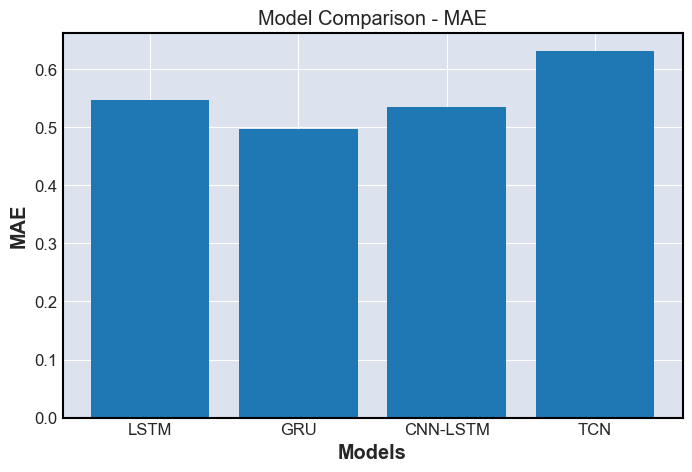

In [42]:
# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Define your models in a dictionary for easier iteration (assuming they are already trained)
models = {
    'LSTM': lstm_model,
    'GRU': gru_model,
    'CNN-LSTM': cnn_lstm_model,
    'Transformer': transformer_model,
    'TCN': tcn_model,
    'LSTM-Transformer': lstm_transformer_model
}

mae_scores = []
successful_models = []

# Generate predictions and calculate MAE for each model
for model_name, model in models.items():
    try:
        # Check the expected input shape of the model
        input_shape = model.input_shape
        
        # Adjust X_test based on the model's input shape
        if input_shape[1] == 10:  # Models that expect 10 time steps
            X_test_reshaped = X_test[:, :10, :]
        elif input_shape[1] == 30:  # Models that expect 30 time steps
            X_test_reshaped = X_test
        else:
            print(f"Warning: Unexpected input shape for model {model_name}: {input_shape}")
            continue

        # Predict using the reshaped input
        y_pred = model.predict(X_test_reshaped)

        # Reshape y_pred if necessary
        if y_pred.shape != y_test.shape:
            y_pred = y_pred.reshape(-1)

        # Calculate MAE
        mae = mean_absolute_error(y_test, y_pred)
        mae_scores.append(mae)
        successful_models.append(model_name)  # Track successful model names
        print(f'{model_name} MAE: {mae}')
    except Exception as e:
        print(f"Error predicting with model {model_name}: {e}")

# Plot the MAE comparison
plt.figure(figsize=(8, 5))
plt.bar(successful_models, mae_scores)  # Use successful model names only
plt.title('Model Comparison - MAE')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.show()


In [ ]:
# Model Selection and Implementation
# Model Choices:
# LSTM: Captures long-term temporal dependencies.
# Transformer: Efficient for long-range patterns.
# TCN (Temporal Convolutional Network): Fast training for long sequences.
# CNN-LSTM: Combines spatial and temporal feature extraction.
# LSTM-Transformer Hybrid: Combines temporal memory with attention mechanisms.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, MultiHeadAttention, LayerNormalization, Input, Add
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, AdamW
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna

# Custom Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * float(tf.math.exp(-0.05))
       

# Enhanced LSTM Model
def create_lstm_model(input_shape, units=64, dropout_rate=0.2):
    model = Sequential([
        Bidirectional(LSTM(units, activation='relu', return_sequences=True, input_shape=input_shape)),
        BatchNormalization(),
        Dropout(dropout_rate),
        LSTM(units, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=AdamW(learning_rate=0.001), loss='mse')
    return model

# Enhanced Transformer Model
def create_transformer_model(input_shape, num_heads=8, key_dim=64, dropout_rate=0.2):
    inputs = Input(shape=input_shape)
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = Add()([inputs, attention])
    attention = LayerNormalization()(attention)

    # Feed Forward Network
    ff = Dense(128, activation='relu')(attention)
    ff = Dropout(dropout_rate)(ff)
    ff = Dense(64, activation='relu')(ff)
    ff = Add()([attention, ff])
    outputs = Dense(1, activation='linear')(ff)

    model = Model(inputs, outputs)
    model.compile(optimizer=AdamW(learning_rate=0.001), loss='mse')
    return model

# Model Evaluation Function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae

# Optuna Hyperparameter Tuning
def objective(trial):
    units = trial.suggest_int('units', 32, 128)
    # lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_heads = trial.suggest_int('num_heads', 4, 12)
    key_dim = trial.suggest_int('key_dim', 32, 128)

    model_choice = trial.suggest_categorical('model', ['lstm', 'transformer'])
    if model_choice == 'lstm':
        model = create_lstm_model((30, 1), units, dropout_rate)
    else:
        model = create_transformer_model((30, 1), num_heads, key_dim, dropout_rate)

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

    model.fit(X_train, y_train, 
              epochs=50, 
              batch_size=batch_size, 
              validation_data=(X_val, y_val), 
              verbose=0, 
              callbacks=[early_stop, lr_scheduler_callback])
    loss = model.evaluate(X_val, y_val, verbose=0)
    return loss

# Optimize using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print(f"Best Parameters: {study.best_params}")

# Train and Evaluate the Best Model
best_params = study.best_params
if best_params['model'] == 'lstm':
    model = create_lstm_model((30, 1), best_params['units'], best_params['dropout_rate'])
else:
    model = create_transformer_model((30, 1), best_params['num_heads'], best_params['key_dim'], best_params['dropout_rate'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

history = model.fit(X_train, y_train, 
                   epochs=50, 
                   # batch_size=best_params['batch_size'], 
                   validation_data=(X_val, y_val), 
                   callbacks=[early_stop, lr_scheduler_callback])

# Evaluate on Test Data
rmse, mae = evaluate_model(model, X_test, y_test)
print(f'Best Model RMSE: {rmse}, MAE: {mae}')
